# Установка библиотек
Для Google Collab - только jaxopt

In [3]:
# %pip install --upgrade jax[cuda12]

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 15.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 25.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 18.3 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 552.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# %pip install jaxopt

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 2.7 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


# Импорт библиотек и модулей

In [2]:
import numpy as onp
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, hessian
from jax import random, config, jit
from jax.nn import sigmoid
from jaxopt import LBFGS
from jax.lax import Precision, stop_gradient
from jax.flatten_util import ravel_pytree

config.update("jax_enable_x64", True)

# Задание seed
Задание свойств генерации случайных чисел: random.key инициализируется целым числом; если нужно изменять seed для набора статистики -- используется генерация целых чисел из numpy

In [36]:
# num = onp.random.randint(low=0, high=1000)
# print(num)

seed = random.key(17)

Функции для инициализации параметров нейронной сети (матриц и столбцов-смещений)

In [37]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-1):
    w_key, b_key = random.split(key)
    
    return scale * random.uniform(w_key, (n, m), minval = - 1/jnp.sqrt(n*m), maxval =  1/jnp.sqrt(n*m)), scale * random.uniform(b_key, (n,), minval = - 1/jnp.sqrt(n), maxval =  1/jnp.sqrt(n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    p = [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys[:-1])]

    return p

Задание основных параметров задачи

In [38]:
# Linear layers sizes
layer_sizes = [1, 10, 10, 10, 5, 5, 5, 5, 1]

# Number of training epochs, number of points (training grid)
num_epochs = 1001
batch_size = 2000

# NN parameters for Deep Ritz method and PINN
params_1 = init_network_params(layer_sizes, seed)
params_2 = init_network_params(layer_sizes, seed)

# Half lenghth of calculation domain
L = 8.

# Generation of grid (equally spaced points) of appropriate shape
points = jnp.expand_dims(jnp.linspace(-L,L, num = batch_size+1), axis = 1)

# Normalizing factor (could be std() of points)
n_factor = L
points = points/n_factor

# Corrdinate of calculation domain boundary 
xb = L/n_factor

# True solution of the problem and its derivative and L2-norm
sol_true = 2*jnp.atan(jnp.exp(points*n_factor))
d_sol_true_dx = 2*jnp.exp(points*n_factor)/(1+jnp.exp(2*points*n_factor))
sol_true_norm = jnp.sqrt(jnp.trapezoid((jnp.squeeze(sol_true))**2, x = points*n_factor, axis = 0)/(2*xb))
print(sol_true_norm.squeeze())

# Properties of true solution and its derivative at boundaries
t0 = jnp.squeeze(sol_true)[0]
t1 = jnp.squeeze(sol_true)[-1]

dt0 = jnp.squeeze(d_sol_true_dx)[0]
dt1 = jnp.squeeze(d_sol_true_dx)[-1]

5.939135122498355


Проверка схожести заданных параметров для двух методов (Deep Ritz и PINN)

In [39]:
jnp.all(ravel_pytree(params_1)[0] == ravel_pytree(params_2)[0])

Array(True, dtype=bool)

Вывод общего числа параметров нейронной сети

In [40]:
ravel_pytree(params_1)[0].shape

(391,)

# Задание структуры нейронной сети
Определение функции Рвачёва и последнего слоя НС, задающего граничные условия

In [41]:
def tanh(x):
    """Just an activation function 
    
    which takes coordinate of a single point as argument x
    """
    return jnp.tanh(x)

def alpha_R(x):
    """Part of Rvachev function
    
    which makes it possible to agjust structure of Rvachev function
    """
    return jnp.ones_like(x)*(0.9)

def R_func_0(x):
    """Definition of Rnachev function's structure"""
    func = (2*xb - jnp.sqrt((x+xb)**2 + (x-xb)**2 - 2*(x+xb)*(xb-x)*alpha_R(x)))/(1+alpha_R(x))

    return func.squeeze()

# Function that evaluates value and gradient w.r.t. x of R_func_0(x)
R_func_val_grad = value_and_grad(R_func_0)

def R_func(x):
    """Function that returns value of Rvachev function and its derivative;
    
    Could be used to additionaly adjust form of R-function
    """
    
    func, dfunc_dx = R_func_val_grad(x)
    # possibly func/r_func_norm, dfunc_dx/r_func_norm
    
    return func, dfunc_dx

# Vectorized version of R_func (for batch fast batch operations)
v_R_func = vmap(R_func)

def boundary_func(x):
    """Function representing boundary conditions;
    
    func1 defines Dirichlet BC
    and func2 defines Neuman BC
    for output of NN
    """
    
    func1 = (t1-t0)/(2*xb)*x + (t0+t1)/2
    dfunc1_dx = jnp.ones_like(x)*(t1-t0)/(2*xb)
    
    func2 = -(dt0+dt1)/(2*xb)*x + (dt0 - dt1)/2

    return func1, dfunc1_dx, func2

def forward(params, x):
    """Function defines how data flow through NN;
    
    this function takes parameters of the model as params and
    coordinate of single grid points as x (per-example "predictions")
    """
    
    # For BC handling
    r_func, dr_func_dx = R_func(x)
    b_func, db_func_dx, n_func = boundary_func(x)
    
    activations = x

    ############################################################################
    w0, b0 = params[0]

    outputs = jnp.dot(w0, activations) + b0
    activations_in = tanh(outputs)

    w1, b1 = params[1]

    outputs = jnp.dot(w1, activations_in) + b1
    activations = tanh(outputs)

    w2, b2 = params[2]

    outputs = jnp.dot(w2, activations) + b2

    outputs = outputs + activations_in
    activations_out = tanh(outputs)

    w3, b3 = params[3]

    outputs = jnp.dot(w3, activations_out) + b3

    activations = tanh(outputs)

    w4, b4 = params[4]

    outputs = jnp.dot(w4, activations) + b4

    activations_in = tanh(outputs)

    w5, b5 = params[5]

    outputs = jnp.dot(w5, activations) + b5

    activations = tanh(outputs)

    w6, b6 = params[6]

    outputs = jnp.dot(w6, activations) + b6
    outputs = outputs + activations_in

    activations_out = tanh(outputs)

    w7, b7 = params[7]

    outputs = jnp.dot(w7, activations_out) + b7

    activations = tanh(outputs)
    ############################################################################

    # res will satisfy BC exactly!
    res = b_func + r_func*n_func - r_func*dr_func_dx*db_func_dx + r_func**2*activations
    
    return jnp.squeeze(res)

# def forward_f(params, x):
#     return jnp.squeeze(forward(params, x))

# Function that returns value and grad of NN's approximated function for Deep Ritz model
deep_ritz = value_and_grad(forward, argnums=1)

# Vectorized version of deep_ritz
v_deep_ritz = vmap(deep_ritz, in_axes = (None, 0))

def pinn_forward(params, x):
    """Function return NN's approximated function and its second derivative for PINN method"""

    d2u_dx2 = hessian(forward, argnums=1)(params, x)

    u = forward(params, x)

    return u, d2u_dx2

# Vectorized version of pinn_forward
v_pinn = vmap(pinn_forward, in_axes = (None, 0))

# Vectorized version of forward, returns just value of NN's approximated function
v_out_value = vmap(forward, in_axes = (None, 0))

Размеры возвращаемых массивов

In [42]:
initial_out_1, initial_dout_dx_1 = v_deep_ritz(params_1, points)
print(initial_out_1.shape)
print(initial_dout_dx_1.shape)

(2001,)
(2001, 1)


In [43]:
initial_dout_dx_1[0]-dt0

Array([-2.45788633e-16], dtype=float64)

In [44]:
initial_out_2, initial_d2out_dx2_2 = v_pinn(params_2, points)
print(initial_out_2.shape)
print(initial_d2out_dx2_2.shape)

(2001,)
(2001, 1, 1)


In [45]:
res = v_out_value(params_1, points)

In [46]:
res.shape

(2001,)

# Структура функции Рвачева

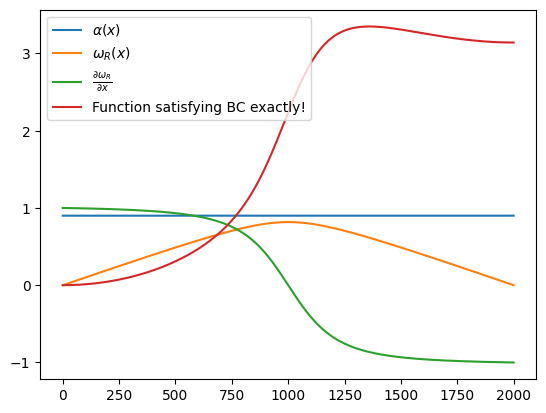

In [47]:
import matplotlib.pyplot as plt

alpha_func = alpha_R(points)
r_func, dr_func_dx = v_R_func(points)
b_func, db_func_dx, n_func = boundary_func(points)

plt.plot(alpha_func, label = r'$\alpha(x)$')
plt.plot(r_func, label = r'$\omega_R(x)$')
plt.plot(dr_func_dx, label = r'$\frac{\partial \omega_R}{\partial x}$')
plt.plot(b_func.squeeze() + 
         r_func.squeeze()*n_func.squeeze() - 
         r_func.squeeze()*dr_func_dx.squeeze()*db_func_dx.squeeze() + 
         r_func.squeeze()**2, label = 'Function satisfying BC exactly!')
plt.legend()
plt.show()

# Структура функций потерь и $L_2$-погрешности

In [48]:
@jit
def loss_deep_ritz(params, points):
    """Loss function for Deep Ritz method"""
    
    out, dout_dx = v_deep_ritz(params, points)
    
    # Division by n_factor caused by coordinate scaling
    return jnp.trapezoid(dout_dx.squeeze()**2/n_factor**2 + jnp.sin(out.squeeze())**2, x = points, axis = 0).squeeze()

@jit
def loss_pinn(params, points):
    """Loss function for PINN method"""
    u, d2u_dx2 = v_pinn(params, points)

    # Division by n_factor caused by coordinate scaling
    return jnp.sum((d2u_dx2.squeeze()/n_factor**2 - jnp.sin(u.squeeze())*jnp.cos(u.squeeze()))**2, axis = 0).squeeze()/(batch_size+1)

@jit
def l2_accuracy(sol, sol_true, points):
    """Function computes L2 ERROR (accuracy is not correct) with trapeziodal rule"""
    
    res = jnp.sqrt(jnp.trapezoid((jnp.squeeze(sol) - jnp.squeeze(sol_true))**2, x = points*n_factor, axis = 0)/(2*L))
    return jnp.squeeze(res)


@jit
def shift_l2_error(sol, sol_true, points):
    """Function computes CORRECTED L2 error with trapeziodal rule"""
    
    y = (sol.squeeze()-jnp.pi/2)**2
    sol_center = jnp.argmin(y)
    
    y = (sol_true.squeeze()-jnp.pi/2)**2
    true_center = jnp.argmin(y)
    
    delta = (points*n_factor)[sol_center] - (points*n_factor)[true_center]
    
    # shifted sol_true
    true_shifted = (2*jnp.atan(jnp.exp(points*n_factor-delta.squeeze()))).squeeze()
    
    return l2_accuracy(sol, true_shifted, points)

@jit
def zero_position(sol):
    """Function return index of \pi/2-value of approximated solution"""
    
    y = (sol.squeeze()-jnp.pi/2)**2
    return jnp.argmin(y)

In [49]:
loss_deep_ritz(params_1, points)

Array(0.50444642, dtype=float64)

In [50]:
loss_pinn(params_2, points)

Array(0.00250578, dtype=float64)

# Цикл обучения

In [51]:
import time

# Hereafter index '1' corresponds to Deep Ritz
# index '2' corresponds to PINN

# Optimizers with hager-zhang linesearch
optimizer_1 = LBFGS(loss_deep_ritz, linesearch = "hager-zhang", max_stepsize=0.05, 
                    linesearch_init='max', history_size = 100, verbose=False)
optimizer_2 = LBFGS(loss_pinn, linesearch = "hager-zhang", max_stepsize=0.05, 
                    linesearch_init='max', history_size = 100, verbose=False)

# Initial optimizators' states
state_1 = optimizer_1.init_state(params_1, points)
state_2 = optimizer_2.init_state(params_2, points)

# Arrays for loss
loss_array_1 = jnp.empty(num_epochs)
loss_array_2 = jnp.empty(num_epochs)

# Arrays for L2-errors
acc_array_1 = jnp.empty(num_epochs)
acc_array_2 = jnp.empty(num_epochs)

# Arrays for corrected L2-errors
s_error_array_1 = jnp.empty(num_epochs)
s_error_array_2 = jnp.empty(num_epochs)

# Arrays for optimizers' learning rates
step_array_1 = jnp.empty(num_epochs)
step_array_2 = jnp.empty(num_epochs)

# Arrays for indexes of \pi/2-values
zero_pos_1 = jnp.empty(num_epochs)
zero_pos_2 = jnp.empty(num_epochs)

# Auxiliary values
acc_check_1 = 100
acc_check_2 = 100

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Losses
    loss_train_1 = loss_deep_ritz(params_1, points)
    loss_train_2 = loss_pinn(params_2, points)
    
    # Updated parameters
    params_1, state_1 = optimizer_1.update(params_1, state_1, points)
    params_2, state_2 = optimizer_2.update(params_2, state_2, points)

    # Solutions
    out_1 = v_out_value(params_1, points)
    out_2 = v_out_value(params_2, points)
    
    # Positions of \pi/2-values
    zero_pos_current_1 = zero_position(out_1)
    zero_pos_current_2 = zero_position(out_2)

    zero_pos_1 = zero_pos_1.at[epoch].set(zero_pos_current_1)
    zero_pos_2 = zero_pos_2.at[epoch].set(zero_pos_current_2)

    loss_array_1 = loss_array_1.at[epoch].set(loss_train_1)
    loss_array_2 = loss_array_2.at[epoch].set(loss_train_2)

    # L2 ERRORS
    acc_current_1 = l2_accuracy(out_1, sol_true, points)
    acc_current_2 = l2_accuracy(out_2, sol_true, points)

    # CORRECTED L2 errors
    s_error_current_1 = shift_l2_error(out_1, sol_true, points)
    s_error_current_2 = shift_l2_error(out_2, sol_true, points)

    # Choose best approximation
    if acc_current_1 < acc_check_1:
      best_p_1 = params_1
      acc_check_1 = acc_current_1

    if acc_current_2 < acc_check_2:
      best_p_2 = params_2
      acc_check_2 = acc_current_2

    # Update arrays
    acc_array_1 = acc_array_1.at[epoch].set(acc_current_1)
    acc_array_2 = acc_array_2.at[epoch].set(acc_current_2)

    s_error_array_1 = s_error_array_1.at[epoch].set(s_error_current_1)
    s_error_array_2 = s_error_array_2.at[epoch].set(s_error_current_2)

    step_array_1 = step_array_1.at[epoch].set(state_1.stepsize)
    step_array_2 = step_array_2.at[epoch].set(state_2.stepsize)

    # Epoch time
    epoch_time = time.time() - start_time

    # Print current values
    if (epoch)%10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set Deep Ritz loss {}".format(loss_train_1))
        print("Deep acc", acc_current_1)
        print("Training set PINN loss {}".format(loss_train_2))
        print("PINN acc", acc_current_2, "\n")

Epoch 0 in 82.70 sec
Training set Deep Ritz loss 0.5044464237566526
Deep acc 0.044190380188451825
Training set PINN loss 0.002505782454930391
PINN acc 0.04612618198930847 

Epoch 10 in 0.21 sec
Training set Deep Ritz loss 0.5000804284987237
Deep acc 0.005813908335727644
Training set PINN loss 0.00018492707507807992
PINN acc 0.006430550296339481 

Epoch 20 in 0.23 sec
Training set Deep Ritz loss 0.5000405897015234
Deep acc 0.0023959982775671887
Training set PINN loss 5.4321638632319625e-05
PINN acc 0.0026856955376777596 

Epoch 30 in 0.22 sec
Training set Deep Ritz loss 0.5000010174513356
Deep acc 0.0019125049407642978
Training set PINN loss 7.951310064972284e-06
PINN acc 0.008777629751732014 

Epoch 40 in 0.22 sec
Training set Deep Ritz loss 0.5000006166263509
Deep acc 0.0002251877388463441
Training set PINN loss 4.199956780496692e-06
PINN acc 0.005207184542288554 

Epoch 50 in 0.23 sec
Training set Deep Ritz loss 0.5000002350719972
Deep acc 0.0024514640202108395
Training set PINN loss

In [52]:
out_1, d_out_dx_1 = v_deep_ritz(params_1, points)
out_2, d2_out_dx2_2 = v_pinn(params_2, points)

best_out_1 = v_out_value(best_p_1, points)
best_out_2 = v_out_value(best_p_2, points)

print(out_1.shape)

(2001,)


# Полученные решения

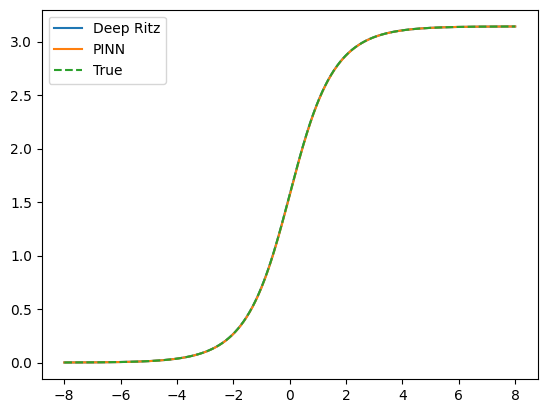

In [53]:
import matplotlib.pyplot as plt
plt.plot(points*n_factor, out_1, label = "Deep Ritz")
plt.plot(points*n_factor, out_2, label = "PINN")
plt.plot(points*n_factor, 2*jnp.atan(jnp.exp(points*n_factor)), "--", label = "True")
plt.legend()
plt.show()

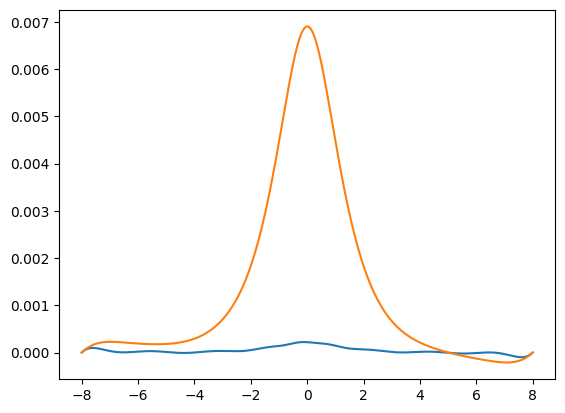

In [54]:
# Poinwise residuals
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(out_1))
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(out_2))

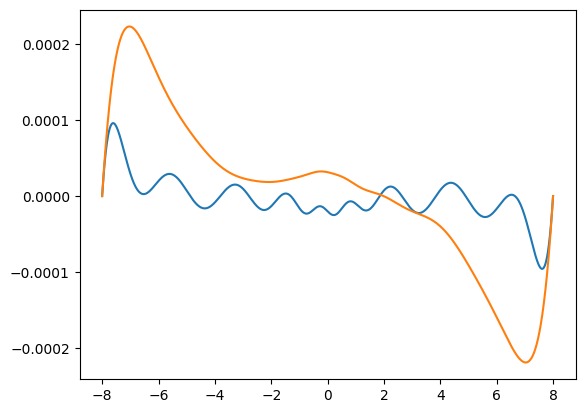

In [55]:
# Poinwise residuals for best approximations
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(best_out_1))
plt.plot(points*n_factor, jnp.squeeze(sol_true)-jnp.squeeze(best_out_2))

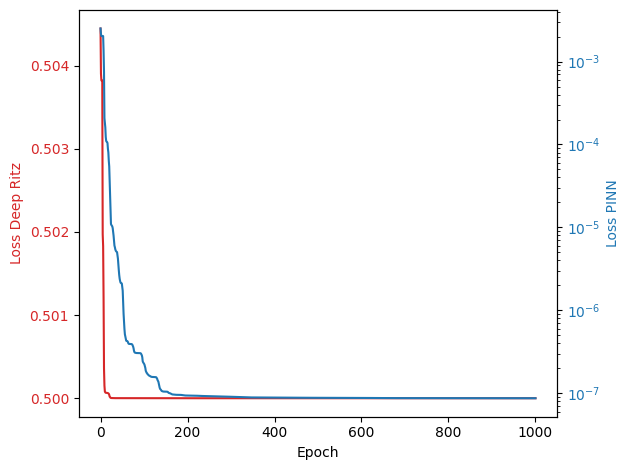

In [56]:
# Print losses 

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Deep Ritz', color=color)
ax1.plot(loss_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss PINN', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(loss_array_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

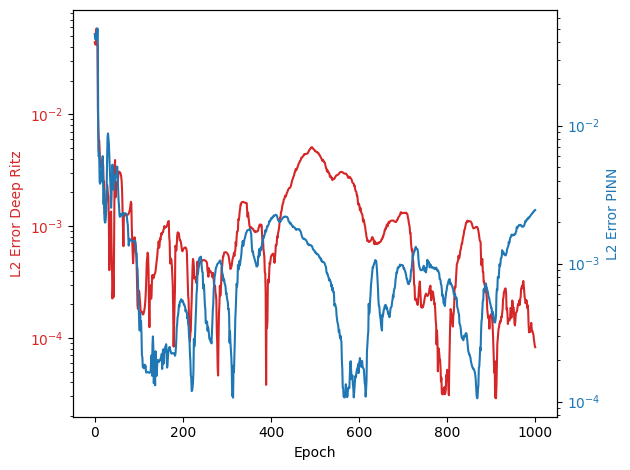

In [57]:
# Print errors

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Error Deep Ritz', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('L2 Error PINN', color=color)  # we already handled the x-label with ax1
ax2.set_yscale('log')
ax2.plot(acc_array_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

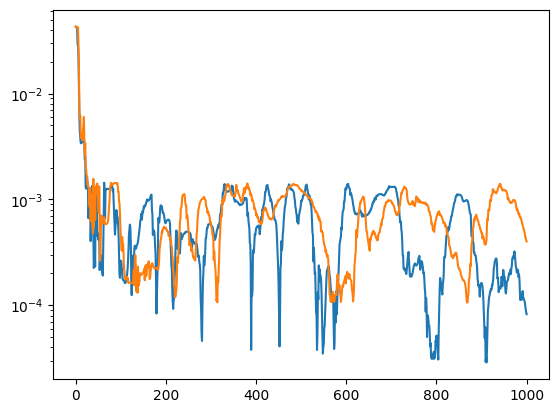

In [58]:
# Print CORRECTED errors

plt.plot(s_error_array_1)
plt.plot(s_error_array_2)
plt.yscale('log')
plt.show()

In [59]:
print("min acc Deep Ritz", jnp.min(acc_array_1))
print("min acc PINN", jnp.min(acc_array_2))

min acc Deep Ritz 2.8827226991046927e-05
min acc PINN 0.00010592825474050521


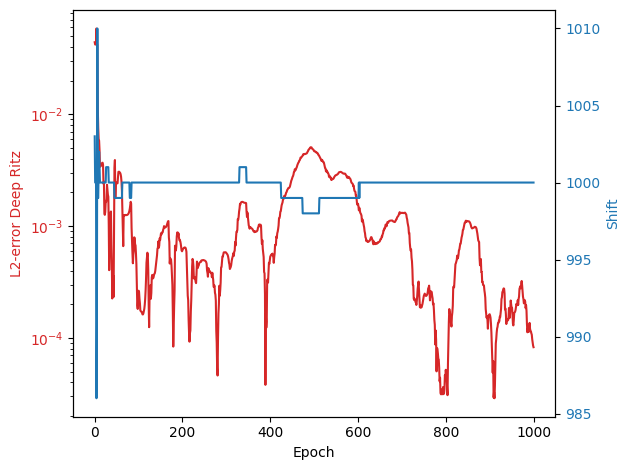

In [60]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2-error Deep Ritz', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Shift', color=color)  # we already handled the x-label with ax1
ax2.plot(zero_pos_1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

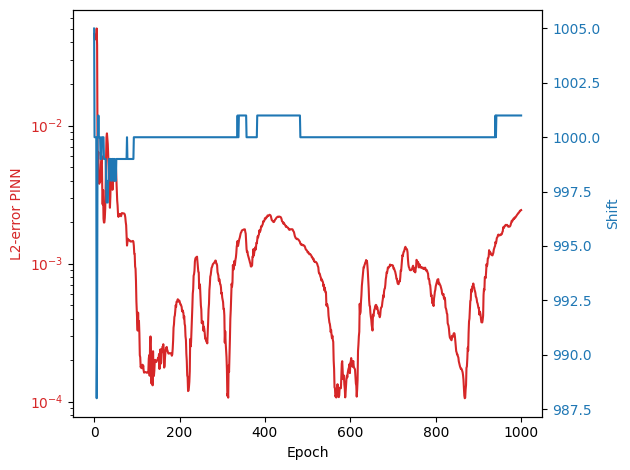

In [61]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2-error PINN', color=color)
ax1.set_yscale('log')
ax1.plot(acc_array_2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Shift', color=color)  # we already handled the x-label with ax1
ax2.plot(zero_pos_2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

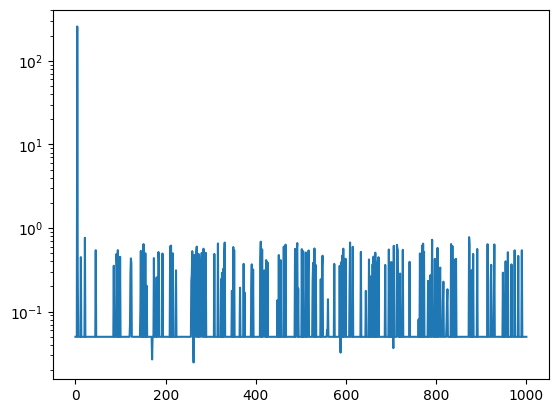

In [62]:
# Print steps

plt.plot(step_array_1)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [63]:
jnp.mean(step_array_1)

Array(0.36585754, dtype=float64)

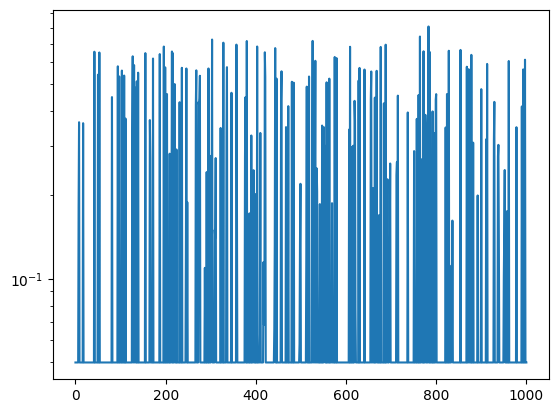

In [64]:
# Print steps

plt.plot(step_array_2)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [65]:
jnp.mean(step_array_2)

Array(0.11448274, dtype=float64)

# Сохранение результатов

In [66]:
np_initial_out_1 = onp.asarray(initial_out_1)
np_initial_dout_dx_1 = onp.asarray(initial_dout_dx_1)

np_initial_out_2 = onp.asarray(initial_out_2)
np_initial_d2out_dx2_2= onp.asarray(initial_d2out_dx2_2)

np_initial_out_total = onp.vstack((np_initial_out_1.squeeze(), 
                                   np_initial_dout_dx_1.squeeze(), 
                                   np_initial_out_2.squeeze(), 
                                   np_initial_d2out_dx2_2.squeeze()))
print(np_initial_out_total.shape)

onp.savetxt("initial_out_total.txt", np_initial_out_total.T, header='dp_out, dp_first_der, pinn_out, pinn_second_der', delimiter=",")

(4, 2001)


In [67]:
np_alpha_func = onp.asarray(alpha_func)

np_r_func = onp.asarray(r_func)
np_dr_func_dx = onp.asarray(dr_func_dx)

np_b_func = onp.asarray(b_func)
np_db_func_dx = onp.asarray(db_func_dx)
np_n_func = onp.asarray(n_func)

np_R_func_total = onp.vstack((np_alpha_func.squeeze(),
                             np_r_func.squeeze(), 
                             np_dr_func_dx.squeeze(),
                             np_b_func.squeeze(),
                             np_db_func_dx.squeeze(),
                             np_n_func.squeeze()))
print(np_R_func_total.shape)

onp.savetxt("R_func_total.txt", np_R_func_total.T, 
            header='alpha_func, r_func, r_func_der, b_func, b_func_der, n_func', delimiter=",")

(6, 2001)


In [68]:
np_out_1 = onp.asarray(out_1)
np_d_out_dx_1 = onp.asarray(d_out_dx_1)

np_out_2 = onp.asarray(out_2)
np_d2_out_dx2_2 = onp.asarray(d2_out_dx2_2)

np_out_total = onp.vstack((np_out_1.squeeze(), np_d_out_dx_1.squeeze(), np_out_2.squeeze(), np_d2_out_dx2_2.squeeze()))
print(np_out_total.shape)

onp.savetxt("out_total.txt", np_out_total.T, header='dp_out, dp_first_der, pinn_out, pinn_second_der', delimiter=",")

(4, 2001)


In [69]:
# out_1, d_out_dx_1 = v_deep_ritz(params_1, points)
# out_2, d2_out_dx2_2 = v_pinn(params_2, points)

In [70]:
onp.savetxt("points.txt", onp.asarray(points.squeeze()), delimiter=",")

In [71]:
np_loss_array_1 = onp.asarray(loss_array_1)
np_loss_array_2 = onp.asarray(loss_array_2)
np_loss_array = onp.vstack((np_loss_array_1, np_loss_array_2))
print(np_loss_array.T.shape)
onp.savetxt("loss.txt", np_loss_array.T, header='loss_dp, loss_pinn', delimiter=",")

(1001, 2)


In [72]:
np_acc_array_1 = onp.asarray(acc_array_1)
np_acc_array_2 = onp.asarray(acc_array_2)
np_acc_array = onp.vstack((np_acc_array_1, np_acc_array_2))
print(np_acc_array.T.shape)
onp.savetxt("error.txt", np_acc_array.T, header='error_dp, error_pinn', delimiter=",")

(1001, 2)


In [73]:
np_s_error_array_1 = onp.asarray(s_error_array_1)
np_s_error_array_2 = onp.asarray(s_error_array_2)
np_s_error_array = onp.vstack((np_s_error_array_1, np_s_error_array_2))
print(np_s_error_array.T.shape)
onp.savetxt("s_error.txt", np_s_error_array.T, header='s_error_dp, s_error_pinn', delimiter=",")

(1001, 2)


In [74]:
np_step_array_1 = onp.asarray(step_array_1)
np_step_array_2 = onp.asarray(step_array_2)
np_step_array = onp.vstack((np_step_array_1, np_step_array_2))
print(np_step_array.T.shape)
onp.savetxt("step.txt", np_step_array.T, header='step_dp, step_pinn', delimiter=",")

(1001, 2)


In [75]:
np_zero_pos_1 = onp.asarray(zero_pos_1)
np_zero_pos_2 = onp.asarray(zero_pos_2)
np_zero_pos = onp.vstack((np_zero_pos_1, np_zero_pos_2))
print(np_step_array.T.shape)
onp.savetxt("zero_pos.txt", np_zero_pos.T, header='zero_pos_dp, zero_pos_pinn', delimiter=",")

(1001, 2)
